In [1]:
"""We define the class for simulating the ORGaNICs model."""
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pytorch_lightning as pl
from model import feedforward
from dataset import MnistDataModule
from spectrum_general import sim_solution
import organics_ml.model.ORGaNICs_models as organics
from torch.func import jacrev, vmap

from organics_ml.utils.utils import dynm_fun
from matplotlib import colors
import numpy as np
from scipy.optimize import fsolve
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
import default_config as config
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.profilers import PyTorchProfiler

torch.set_float32_matmul_precision('medium')

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
cmap = 'viridis'

In [2]:
# We load the model first
# model_name = "MNIST"
model_name = "MNIST_multilayer_layer_120_60"
# model_name = "MNIST_MLP_80"
# model_name = "MNIST_MLP_120_60"
PERMUTED = False
folder_name = "tb_logs"
version = 0

In [3]:
def load_model(epoch_number=None, model_name=None, folder_name=None, version=0):
    checkpoint_folder = f'{folder_name}/{model_name}/version_{version}/checkpoints/'
    hparams_path = f'{folder_name}/{model_name}/version_{version}/hparams.yaml'
    checkpoint_files = os.listdir(checkpoint_folder)
    epoch_idx = [int(file.split('epoch=')[1].split('-')[0]) for file in checkpoint_files]

    if epoch_number is not None:
        # If epoch number is provided, find the index of that epoch
        max_idx = epoch_idx.index(epoch_number)
    else:
        # If epoch number is not provided, find the index of the max epoch
        max_idx = epoch_idx.index(max(epoch_idx))

    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_files[max_idx])
    # print(checkpoint_path)
    model = feedforward.load_from_checkpoint(checkpoint_path=checkpoint_path, map_location='cpu', hparams_file=hparams_path)
    model.eval()
    return model

In [4]:
logger = TensorBoardLogger(folder_name, name="Inference")
dm = MnistDataModule(
    data_dir=config.DATA_DIR,
    batch_size=2000,
    num_workers=2,
    permuted=PERMUTED,
)
# calculate training accuracy using pytorch lightning
trainer = pl.Trainer(
    logger=logger,
    max_epochs=1
)

epoch_no = None
model = load_model(epoch_no, model_name, folder_name, version)

trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                  0.9805
         test_f1                  0.9805
        test_loss           0.13729091414034483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9805, 'test_f1': 0.9805, 'test_loss': 0.13729091414034483}]

In [5]:
model.eval()

# We define the ORGaNICs parameters
# organics_model = model.org1
organics_model = model.org2

N = organics_model.output_size
tauA = 2.0 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 2.0 + 0 * torch.abs(torch.randn(N) * 0.001)

# defining parameters from the model
Wzx = organics_model.Wzx
Wyy = organics_model.Wr()
Way = organics_model.Way()
sigma = organics_model.sigma
b0 = organics_model.B0()

In [6]:

# defining the input dependent parameters
# define x to be the test dataset
# x = model.activations['org1_input'].clone().to(device)
x = model.activations['org2_input'].clone().to(device)
z = F.linear(x, Wzx, bias=None)
z = z / torch.norm(z, dim=1, keepdim=True)
b1 = organics_model.B1(x)


In [7]:
# Define the dynamical function
def _dynamical_fun(vect, z, b1):
    """
    This function defines the dynamics of the ring ORGaNICs model.
    :param x: The state of the network.
    :return: The derivative of the network at the current time-step.
    """
    y = vect[0:N]
    a = vect[N:]
    dydt = (1 / tauY) * (-y + b1 * z
            + (1 - torch.sqrt(torch.relu(a))) * (Wyy @ y))
    dadt = (1 / tauA) * (-a + (sigma * b0) ** 2 + Way @ (torch.relu(a) * y ** 2))
    return torch.cat((dydt, dadt))

In [8]:
max_real_eigenvals = torch.zeros((x.size(0)), dtype=torch.float32)
num_inputs = x.size(0)


for idx in range(num_inputs):
    z_new = z[idx, :]
    b1_new = b1[idx, :]
    output_y, output_a = organics_model.steady_state(None, b1_new.unsqueeze(0), b0, z_new.unsqueeze(0))
    vect = torch.cat((output_y, output_a), dim=1)
    vect_new = vect.squeeze(0)
    jac = jacrev(_dynamical_fun)(vect_new, z_new, b1_new)
    # jacobians[idx, :, :] = jac
    # eigenvals[idx, :] = torch.linalg.eigvals(jac)
    max_real_eigenvals[idx] = torch.max(torch.real(torch.linalg.eigvals(jac)))


In [9]:
# Save the tensor max_real_eigenvals
torch.save(max_real_eigenvals, f'./eigenvals_second_layer_{model_name}.pt')

In [ ]:

# Checking the consistency of the output
# output = model.activations['org1_output'].clone().to(device)
# output = model.activations['org2_output'].clone().to(device)
output_y, output_a = organics_model.steady_state(x, b1, b0, z)
vect = torch.cat((output_y, output_a), dim=1)

# print(torch.allclose(output, torch.relu(output_y) ** 2, atol=1e-5))

In [7]:
num_inputs = 1000
# jacobians = torch.zeros((num_inputs, N * 2, N * 2))
# eigenvals = torch.zeros((num_inputs, N * 2), dtype=torch.complex64)
max_real_eigenvals = torch.zeros((num_inputs), dtype=torch.float32)

for idx in range(num_inputs):
    z_new = z[idx, :]
    b1_new = b1[idx, :]
    vect_new = vect[idx, :]
    jac = jacrev(_dynamical_fun)(vect_new, z_new, b1_new)
    # jacobians[idx, :, :] = jac
    # eigenvals[idx, :] = torch.linalg.eigvals(jac)
    max_real_eigenvals[idx] = torch.max(torch.real(torch.linalg.eigvals(jac)))

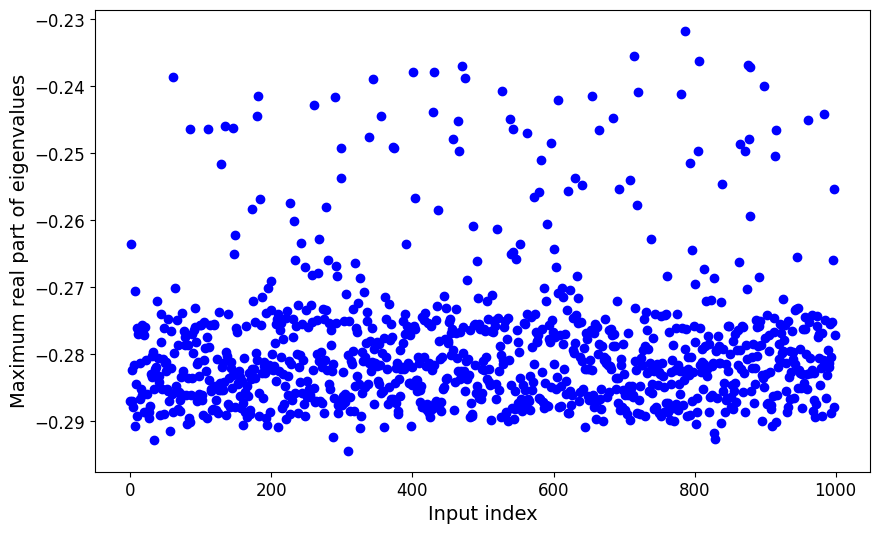

In [8]:
# Find the maximum of real parts of all eigenvalues for all num_inputs and plot them
# max_real_eigenvals = torch.max(torch.real(eigenvals), dim=1).values


# Plotting the scatter plot
plt.figure(figsize=(10, 6))  # Larger figure size
plt.scatter(range(len(max_real_eigenvals)), max_real_eigenvals.detach().numpy(), color='b')  # Scatter plot
plt.xlabel('Input index', fontsize=14)  # Increase font size for x-label
plt.ylabel('Maximum real part of eigenvalues', fontsize=14)  # Increase font size for y-label
plt.xticks(fontsize=12)  # Increase font size for x-ticks
plt.yticks(fontsize=12)  # Increase font size for y-ticks
plt.show()